In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from google.cloud import bigquery
from google.cloud import bigquery_storage

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/rsfagundes/Documents/keys/segment-generator-e51ee8f89983.json"


In [35]:
client = bigquery.Client()
bqstorage = bigquery_storage.BigQueryReadClient()

E0000 00:00:1758991631.648591   51035 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


<br>
<br>
<h2>Exercise 1 - Calculate the revenue contribution of each traffic source, considering only first-touch attribution. Which traffic source has the highest impact on revenue?</h2>

In [42]:
query = """
WITH
  first_touch AS (
  SELECT
    user_id,
    traffic_source AS first_touch_source,
    SUM(revenue) OVER (PARTITION BY user_id ) AS user_total_revenue
  FROM
    eduki_test.marketing_analytics
  QUALIFY
    ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY purchase_date ) = 1 )
SELECT
  first_touch_source,
  ROUND(SUM(user_total_revenue), 2) AS total_revenue,
  ROUND( 100 * SUM(user_total_revenue) / SUM(SUM(user_total_revenue)) OVER (), 2 ) AS revenue_share
FROM
  first_touch
GROUP BY
  first_touch_source
ORDER BY
  total_revenue DESC;
"""

df1 = client.query(query).to_dataframe(bqstorage_client=bqstorage)

df1.head()

,first_touch_source,total_revenue,revenue_share
0,Paid Search,148772.73,17.90
1,Direct,141955.49,17.08
2,Email,141477.52,17.03
3,Referral,136105.47,16.38
4,Social Media,134015.42,16.13


/var/folders/74/ctw0cxv57bv_0qt4034v71_c0000gn/T/ipykernel_2889/85173770.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90, ha="center")


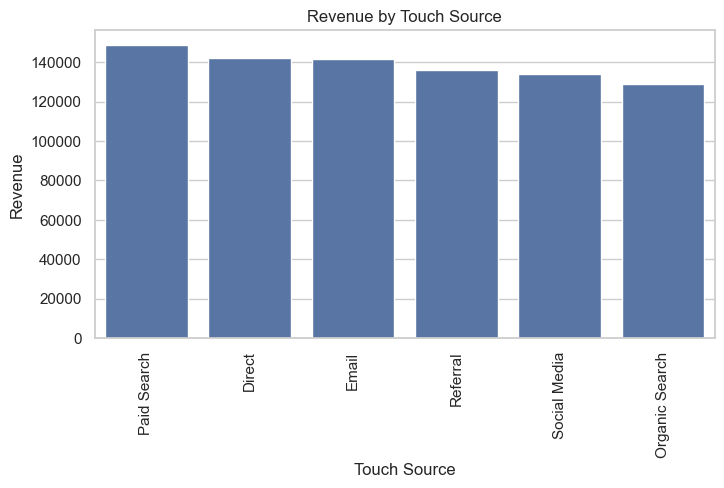

In [64]:
fig, ax = plt.subplots(figsize=(8,4))
sns.set_theme(style="whitegrid")
sns.barplot(data=df1, x="first_touch_source", y="total_revenue", ax=ax)

ax.set_title("Revenue by Touch Source")
ax.set_xlabel("Touch Source")
ax.set_ylabel("Revenue")

labels = [textwrap.fill(l, 15) for l in df1["first_touch_source"].unique()]
ax.set_xticklabels(labels, rotation=90, ha="center")
plt.show()


<br>
<br>
<h2>Exercise 2 - Identify customers who made a second purchase within 30 days after their first purchase. What percentage of total customers do they represent?</h2>

In [38]:
query = """
WITH
  first_rows AS (
  SELECT
    user_id,
    purchase_date,
    LEAD(purchase_date) OVER (PARTITION BY user_id ORDER BY purchase_date) AS next_purchase
  FROM
    `eduki_test.marketing_analytics`
  QUALIFY
    ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY purchase_date) = 1 )
SELECT
  ROUND(100 * COUNTIF(TIMESTAMP_DIFF(next_purchase, purchase_date, DAY) <= 30) / COUNT(*), 2) AS pct_second_purchase
FROM
  first_rows;
"""

df2 = client.query(query).to_dataframe(bqstorage_client=bqstorage)

df2.head()

,pct_second_purchase
0,18.51


/var/folders/74/ctw0cxv57bv_0qt4034v71_c0000gn/T/ipykernel_2889/3092214154.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = df2.iloc[0][0]


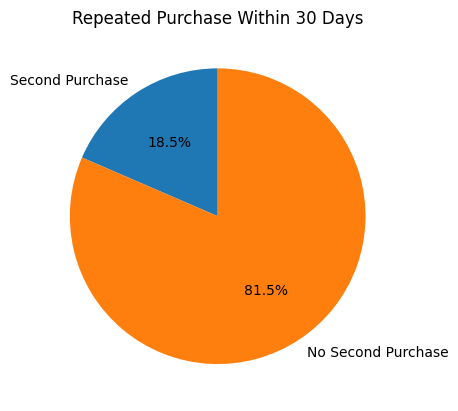

In [ ]:
x = df2.iloc[0][0]

labels = ["Second Purchase", "No Second Purchase"]
values = [x, 100-x]


fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct="%1.1f%%", startangle=90)

ax.set_title("Repeated Purchase Within 30 Days")
plt.show()

<br>
<br>
<h2>Exercise 3 - Compute the ROAS (Return on Advertising Spend) for each campaign. Which campaigns are below the break-even point and should be optimized or paused?</h2>

In [39]:
query = """
SELECT
  campaign_id,
  campaign_name,
  ROUND(SUM(ad_spent),2) AS ad_spent,
  ROUND(SUM(revenue),2) AS revenue,
  ROUND(SAFE_DIVIDE(SUM(revenue),SUM(ad_spent)),2) AS ROAS,
  CASE
    WHEN SAFE_DIVIDE(SUM(revenue),SUM(ad_spent)) < 2 THEN 'Optmize or Pause'
    ELSE 'Performing well'
END
  AS Recomendation
FROM
  `eduki_test.marketing_analytics`
WHERE
  campaign_name IS NOT NULL
GROUP BY
  campaign_id,
  campaign_name
ORDER BY
  ROAS DESC;
"""

df3 = client.query(query).to_dataframe(bqstorage_client=bqstorage)

df3.head()

,campaign_id,campaign_name,ad_spent,revenue,ROAS,Recomendation
0,101,Google Ads - Spring Sale,28297.52,76971.18,2.72,Performing well
1,202,Instagram - Summer Deal,25303.84,68617.28,2.71,Performing well
2,201,Facebook - Holiday Promo,42161.41,61287.46,1.45,Optmize or Pause
3,302,VIP Email - Exclusive Discount,47631.24,68170.07,1.43,Optmize or Pause
4,301,Newsletter - Monthly Offer,98896.04,67744.99,0.69,Optmize or Pause


/var/folders/74/ctw0cxv57bv_0qt4034v71_c0000gn/T/ipykernel_2889/33097720.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90, ha="center")


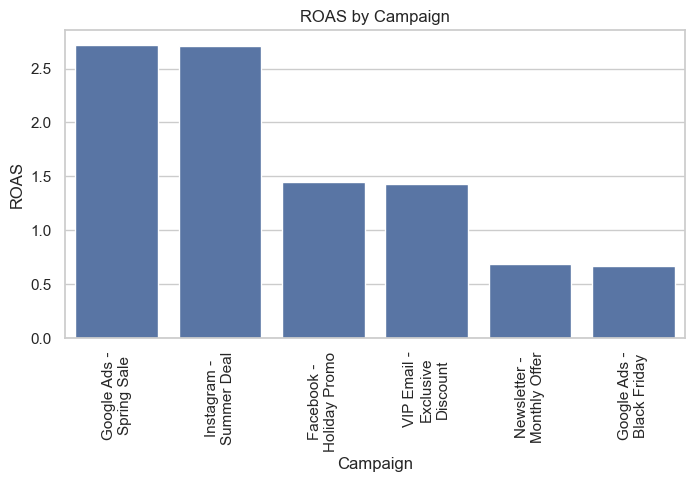

In [63]:
fig, ax = plt.subplots(figsize=(8,4))
sns.set_theme(style="whitegrid")
sns.barplot(data=df3, x="campaign_name", y="ROAS", ax=ax)

ax.set_title("ROAS by Campaign")
ax.set_xlabel("Campaign")
ax.set_ylabel("ROAS")

labels = [textwrap.fill(l, 15) for l in df3["campaign_name"].unique()]
ax.set_xticklabels(labels, rotation=90, ha="center")

plt.show()